In [32]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import joblib


In [45]:
# Load the saved model
knn = joblib.load('best_knn_model.pkl')
nb = joblib.load('best_nb_model.pkl')
lr = joblib.load('best_lr_model.pkl')
svm = joblib.load('best_svm_model.pkl')
rf = joblib.load('best_rf_model.pkl')
ada = joblib.load('best_adaboost_dt_model.pkl')

In [34]:
df = pd.read_csv("Cleaned.csv")

X = np.array(df.drop(['Grade'], 1))
y = np.array(df['Grade'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


C:\Users\ajed8\AppData\Local\Temp\ipykernel_26672\12585974.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['Grade'], 1))


In [46]:
eclf = VotingClassifier(estimators=[('KNN', knn), ('NB', nb),
                                    ('LR', lr), ('SVM', svm), ('RF', rf), ('Ada', ada)],
                        voting='hard')

eclf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = eclf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       122
           1       0.85      0.90      0.87        88

    accuracy                           0.89       210
   macro avg       0.89      0.89      0.89       210
weighted avg       0.89      0.89      0.89       210



In [47]:
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from matplotlib import pyplot

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
	return scores

def get_models(X, y):
    models = dict()
    models['KNN'] = knn
    models['NB'] = nb
    models['LR'] = lr
    models['SVM'] = svm
    models['RF'] = rf
    models['Ada'] = ada

    models['soft_voting'] = get_voting(X, y)
    return models


def get_voting(X, y):
    models = list()
    models.append(('KNN', knn))
    models.append(('NB', nb))
    models.append(('LR', lr))
    models.append(('SVM', svm))
    models.append(('RF', rf))
    models.append(('Ada', ada))

    # compute model accuracies using cross-validation
    accuracies = {}
    for name, model in models:
        scores = evaluate_model(model, X, y)
        accuracies[name] = mean(scores)

    # compute model weights based on accuracies
    weights = {}
    total_acc = sum(accuracies.values())
    for name, acc in accuracies.items():
        weights[name] = acc / total_acc

    # define the voting ensemble with dynamic weights
    ensemble = VotingClassifier(estimators=models, voting='soft', weights=list(weights.values()))
    return ensemble

>KNN 0.866 (0.037)
>NB 0.733 (0.044)
>LR 0.875 (0.031)
>SVM 0.872 (0.035)
>RF 0.873 (0.035)
>Ada 0.801 (0.034)
>soft_voting 0.874 (0.033)


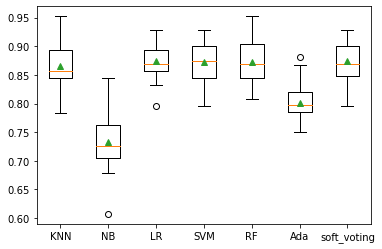

>soft_voting_dynamic_weights 0.873 (0.034)


In [48]:
# get the models to evaluate
models = get_models(X, y)

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# compare model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# evaluate the soft voting ensemble with dynamic weights
ensemble = models['soft_voting']
scores = evaluate_model(ensemble, X, y)
print('>soft_voting_dynamic_weights %.3f (%.3f)' % (mean(scores), std(scores)))


In [49]:
# fit the soft voting ensemble with dynamic weights
ensemble = get_voting(X, y)
ensemble.fit(X, y)
print(ensemble.weights)

[0.17236937314342293, 0.14590696168786654, 0.174188818645746, 0.17363851016832965, 0.17380131769365523, 0.16009501866097953]


In [51]:
from sklearn.metrics import classification_report

ensemble.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = ensemble.predict(X_test)

print("Test Accuracy:", ensemble.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=3))

Test Accuracy: 0.8809523809523809
Classification Report:
              precision    recall  f1-score   support

           0      0.922     0.869     0.895       122
           1      0.832     0.898     0.863        88

    accuracy                          0.881       210
   macro avg      0.877     0.883     0.879       210
weighted avg      0.884     0.881     0.881       210



C:\Users\ajed8\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


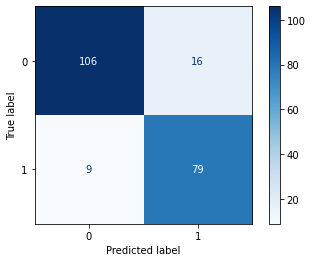

In [27]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(ensemble, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

In [40]:
y_scores = ensemble.predict_proba(X)[:, 1]

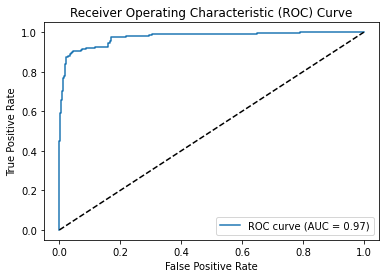

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
y_scores = ensemble.predict_proba(X)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_scores)
auc = roc_auc_score(y, y_scores)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
print(auc)

0.9748585390946503


In [50]:
def get_model_hyperparameters(model):
    hyperparameters = {}

    # Retrieve all parameters of the model
    model_params = model.get_params()

    # Filter out non-hyperparameters
    for param, value in model_params.items():
        if isinstance(value, (int, float, str, bool)) or value is None:
            hyperparameters[param] = value

    return hyperparameters

# Get the hyperparameters for each model
model_hyperparameters = {}
for name, model in models.items():
    model_hyperparameters[name] = get_model_hyperparameters(model)

# Print the hyperparameters for each model
for name, hyperparameters in model_hyperparameters.items():
    print(f"Hyperparameters for {name}:")
    if hyperparameters:
        for param, value in hyperparameters.items():
            print(f"{param}: {value}")
    else:
        print("No hyperparameters found.")
    print()


Hyperparameters for KNN:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 13
p: 2
weights: uniform

Hyperparameters for NB:
priors: None
var_smoothing: 1e-07

Hyperparameters for LR:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False

Hyperparameters for SVM:
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: 0.1
kernel: linear
max_iter: -1
probability: True
random_state: None
shrinking: True
tol: 0.001
verbose: False

Hyperparameters for RF:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: auto
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 5
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oo